In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.special import expi
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

In [2]:
from numba import jit

In [3]:
class ODEsolvers():
    '''
    a class containing solvers that solves for an equation of the form 
    d/dt(y) = f(y,t)
    this class takes a slope function, a method that calculates the step in value of y
    
    '''
    def __init__(self, slope_func, method ='rk4' ):
        '''
        initiates the ODE solver with a slope function and a step method 
        '''
        self.slope = slope_func
        self.set_method(method)
    
    def set_method(self, method):
        '''
        sets the method to calculate increment from y_i to y_(i+1)
        '''
        match method:
            case 'euler':
                self.increment = self.euler
            case 'rk2':
                self.increment = self.rk2
            case 'rk4':
                self.increment = self.rk4
            case other:
                print(f'{method} not implemented, choosing rk4 instead.')
                self.increment = self.rk4
        
    def euler(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        eulerstep = self.slope(y,t,*pparams,**nparams)*dt
        return(eulerstep)
    
    def rk2(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        return k2
    
    def rk4(self,y,t, dt,*pparams, **nparams):
        '''
        returns the increment to the parameter y 
        '''
        k1=dt*self.slope(y,t,*pparams,**nparams)
        k2=dt*self.slope(y+k1/2,t+dt/2,*pparams,**nparams)
        k3=dt*self.slope(y+k2/2,t+dt/2,*pparams,**nparams)
        k4=dt*self.slope(y+k3,t+dt,*pparams,**nparams)
        return (k1+2*k2+2*k3+k4)/6
    
    def solver(self,y,t,dt,*slope_pparams,**slope_nparams):
        '''
        This function takes y(t) and returns the values of 
        y(t+dt) using a specified method and slope function
        '''
        y_now=y
        step = self.increment(y_now, t, dt, *slope_pparams,**slope_nparams)
        y_next = y_now + step
        
        return(y_next)
    
    
    

In [4]:
class CSTRModel():
    '''
    This class makes a Continuous-Stirred-Tank-Reactor model 
    and provides methods to perform time domain simulations on it
    given model properties 
    '''
    
    def __init__(self, tau=2, N=1, timedata={}, c_init='empty',inj_prot=None):
        '''
        params:  make sure all the units are consistent
            tau : V/q time taken to replace the whole volume of the tank
            N : number of subtanks the whole volume is divided into.
            timedata:
                the time data for simulation. this can be provided in two ways
                 1. a dictionary containing {'t_start, dt , t_end'}
                    t_start  : simulation end time 
                    dt: time diff between each simulation step
                    t_end  : simulation end time 
                 2. a list of simulation time stamps
            c_init : initial concentration of tracer in each spatial grid
                   : takes values {'first', 'empty', list }
                   : 'first' - case where first (0th) cell has a tracer conc
                   : 'empty' - case where the whole volume has 0 tracer conc
                   : list: list of tracer conc in each of the grid cell
            inj_protocol: injection protocol to use 
                   : takes values {'rect_1s', 'rect_2s', 'rect_3s', 
                                   'ramp_1s', 'ramp_2s', 'biphasic'}

        '''
        # set and initialize temporal parameters 
        self.make_time(timedata)
        
        # set and initialize spatial parameters 
        self.make_spatial( N, c_init)
        
        # injection protocol. cinj stores the concentration of injection 
        # create a list of concs being injected at each time step
        self.make_injection_protocol(inj_prot)
        
        # store model parameters
        self.tau = tau   # physical model parameter
        
    def make_injection_protocol(self, protocol):
        '''
        makes injection protocol
        '''
        self.inj_prot = protocol
        match protocol:
            case 'rect_1s':
                self.inj_t = [0,1.,1.,2.,3.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_2s':
                self.inj_t = [0,2.,2.,3.,4.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'rect_3s':
                self.inj_t = [0,3.,3.,4.,5.]
                self.inj_c = [1, 1, 0, 0, 0]
            case 'ramp_1s':
                self.inj_t = [0,1.,1.,2.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'ramp_2s':
                self.inj_t = [0,2.,2.,3.,5.]
                self.inj_c = [0, 1, 0, 0, 0]
            case 'biphasic':
                self.inj_t = [  0,1.0,1.,2.,2.,3.,3.,4.]
                self.inj_c = [0.7,0.7,0.,0 ,1 ,1 ,0 ,0 ]
            case None:
                self.inj_t = [0,1.]
                self.inj_c = [0, 0]
        
    def cinj(self, t):
        '''
        returns injection concentration at a given time
        '''
        return(np.interp(t,self.inj_t, self.inj_c))
        
    def make_spatial(self, N, c_init='empty'):
        # set initial condition of concs before sim starts
        self.N = int(N)  #number of mixing tanks in series
        match c_init: 
            case str():
                match c_init:
                    case 'first':
                        c_init = np.zeros(self.N)
                        c_init[0] = 1     # set the tracer concentration in first mixing tank to 1
                                          # conc in all other tanks is 0
                    case 'empty':
                        c_init = np.zeros(int(self.N)) # there are no trancer conc anywhere else
            case list() | np.ndarray():
                c_init = c_init   # set the initial concentrations of tanks if its provided. 
            case other:
                print('Node signature not recognized')
        self.c_init=c_init

    def make_time(self, timedata):
        '''
        set model time paramters
        '''
        match timedata:
            case list() | np.ndarray():
                #print('its a list')
                self.ts = np.array(timedata)
                self.t_st, self.t_end = timedata[0], timedata[-1]
            case dict():
                self.t_st = timedata['t_start']
                self.t_end = timedata['t_end']
                dt = timedata['dt']
                self.ts = np.arange(self.t_st, self.t_end,dt)
                self.ts=np.append(self.ts, self.t_end)
            case other:
                print('Time signature not recognized')
        self.dts = self.ts[1:]- self.ts[:-1]
        
    def cstr(self, conc, ti,N=2,tau=2):
        '''
        this function provides the time derivative for the concentration 
        in a mixing tank at ti.
        CSTR time differencial
        f = d/dt(concentration) = slope = n/tau*(delta concentration)
            delta concentration in the equation above is the difference between 
            concentration in the nth tank and n-1th tank     
        input:
                conc : a numpy list of concentrat in n number of nodes at time step ti
                ti   : time at which the slope is being derived (note: in this model ti is not used)
                n    : number of tanks in series
                tau  : some parameter of the mixing tank (units = time)
                cinj : the concentration of the fluid being injected into the 0th mixing tank
                       at the ith time step.
        '''
        #print(ti, ts)
        #tau=self.tau
        #N=self.N
        #print(N)
        Cinj_t = self.cinj(ti) # injection concentration at ti
        c = np.append(Cinj_t, conc)  # we append the injection
        slope = N/tau*(c[:-1]-c[1:])
        #print('conc including injection:',c)
        return(slope)
    
    def time_sim(self, N, tau, c_init='empty', ODEmethod='rk4'): 
        '''
        Performs the time domain simulation on the model. 
        It is possible to change the model parameters N and tau at runtime
        returns the concentration c_out (concentration in the last tank.)
        
        '''
        # solution.append(list(self.y_0))
                
        # remake the grids
        self.make_spatial(N,c_init)
        self.tau=tau
        
        c_now = self.c_init    # set conc values to initial value
        #print('assigning c_init', c_now)
        c_out=c_now[-1:]      #save 
        
        slope_func=self.cstr
        s = ODEsolvers(slope_func=slope_func, method=ODEmethod)
        solver = s.solver
        nparams = {'N': self.N, 'tau':self.tau}
        for t,dt in zip(self.ts[:-1], self.dts):
            #print('conc matrix i m passing', c_now)
            c_next = solver(c_now, t, dt, **nparams)
            #print('slope matrix i m passing', step)
            #c_next = c_now+step
            c_out=np.append(c_out,c_next[-1])
            #solution.append(y_next)
            c_now= c_next
            #print(c_now)
        return c_out       
    
    def analytical(self, c0=1):
        '''
        Returns the analytical solution to a CSTR model
        the analytical solution is avaiable for max 3 cells
        the analytical solution is possible for 4 cells or higher
        '''
        ts = self.ts
        tau = self.tau
        match self.N:
            case 1:
                return c0*np.exp(-ts/tau)
            case 2:
                return 2*c0*ts/tau*np.exp(-2*ts/tau)
            case 3:
                return c0*9*ts*ts/2/tau/tau*np.exp(-3*ts/tau)
            case other:
                print('Not implemented')
                return(None)
            
    def props(self):
        '''
        this method is used for debugging
        returns the assigned attributes of the
        '''
        return [i for i in cls.__dict__.keys() if i[:1] != '_']
    
    def __repr__(self):
        out = f'CSTRModel(tau={self.tau}, N={self.N}, dt={self.dt}, Tmax={self.Tmax},c_init={self.c_init},inj_prot={self.inj_prot}))'
        return(out)
    
    def __str__(self):
        out = f'A CSTR model with {self.N} tanks and  residence time of {self.tau}s. \n'+\
        f'Simulation time:[0s to {self.Tmax}s with timesteps {self.dt}].\n'+\
        f'Initial concentration is {self.c_init} and injection protocol is {self.inj_prot}'
        return(out)    
    

# Exercise 1: 

## Part 1
Implemented OED solver and made a CSRT model 

## Part 2
Test you implementation against the analytical solutions in equation (3)
for n = 1, 2 and 3.

In [5]:
def comparision_plot(N,dt,ts,analitical, soln1, soln2, soln3):
    '''
    creates plots for of the time sim results 
    for various solver methods vs analytical soln
    '''
    # ignore the values when t= 0
    ts,analitical, soln1, soln2, soln3 = ts[1:],analitical[1:], soln1[1:], soln2[1:], soln3[1:]
    
    #print(soln1,soln2,soln3)
    fig, axs=plt.subplots(nrows=2)
    
    ax=axs[0]
    ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, soln1,'-*',markersize=7, label='numerical, euler')
    ax.plot(ts, soln2,'-*',markersize=5, label='numerical, rk2')
    ax.plot(ts, soln3,'-*',markersize=2, label='numerical, rk4')
    ax.set(xlabel='time ', ylabel='conc. at tank exit')
    ax.set(title = f'Change in exit conc over time,\n N of tank:{N}, deltaT: {dt}')
    ax.legend()
    
    ax=axs[1]
    #ax.plot(ts, analitical,'-o',markersize=7, label='analytical')
    ax.plot(ts, np.abs(soln1-analitical),'-*',markersize=7, label='numerical, euler')
    ax.plot(ts, np.abs(soln2-analitical),'-*',markersize=5, label='numerical, rk2')
    ax.plot(ts, np.abs(soln3-analitical),'-*',markersize=2, label='numerical, rk4')
    ax.set(xlabel='time ', ylabel='error', yscale='log')
    ax.set(title = f'Error,\n N of tank:{N}, deltaT: {dt}')
    ax.legend()
    plt.tight_layout()


In [6]:
def method_comparision(tau=2, N=1,dt=3,Tmax=20,c_init='first'):
    timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
    #nparams = model.nparams#
    
    methods = ['euler', 'rk2', 'rk4']
    soln = [0]*len(methods)
    for i, method in enumerate(methods):
        soln[i]=model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)
    
    #print(soln1,soln2,soln3)
    ts=model.ts
    analitical= model.analytical()
    comparision_plot(N,dt,ts,analitical, *soln)

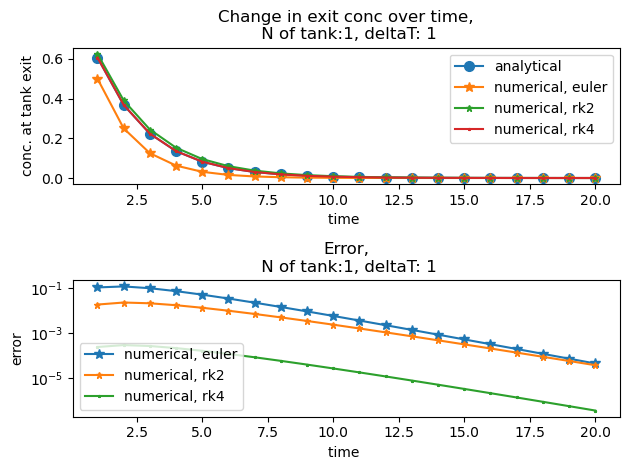

In [7]:
method_comparision(tau=2, N=1, dt=1, Tmax=20, c_init='first')

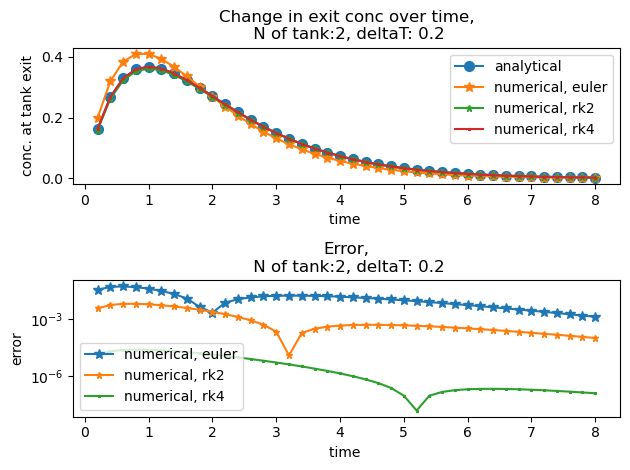

In [8]:
method_comparision(tau=2, N=2, dt=0.2, Tmax=8, c_init='first')

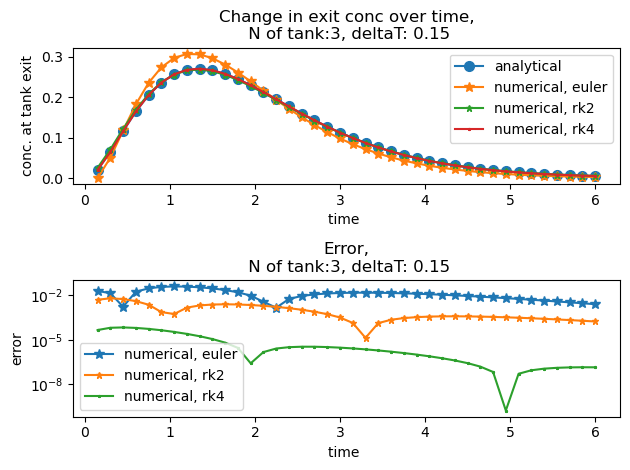

In [9]:
method_comparision(tau=2, N=3, dt=0.15, Tmax=6, c_init='first')

## Part 3. 
Pick n =1, 2, or 3
1. plot the numerical error at t = 1, for the last tank, and for dt values in
the range 0.1, . . . 0.001. (You may try lower values if you have a very fast
solver)
2. does the numerical error scale as expected for Euler, RK2, and RK4?

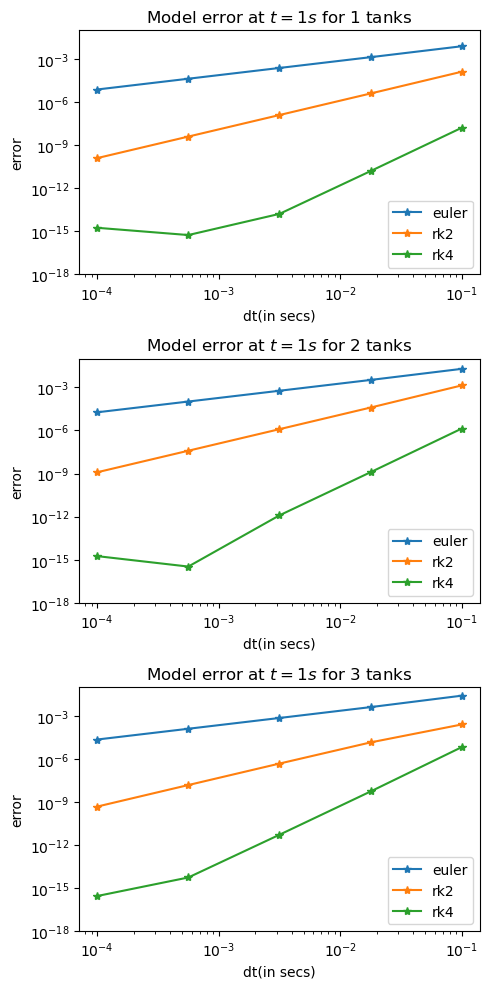

In [26]:
# parameters. do this for finer dt scaling
n = 4 # used to calculated 10**-n
tau = 2
Tmax = 1 # time at which the error is calculated
c_init = 'first'  # initial concs in the tanks

# time deltas
dts = np.geomspace(.1, 10**-n, n+1)
# print(dts)

# make the figure
fig, axs = plt.subplots(nrows = 3, figsize=(5,10))
for N, ax in zip([1,2,3], axs):    
    for method in ['euler', 'rk2', 'rk4']:
        error = []
        for dt in dts:
            # make model
            timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
            model = CSTRModel(tau=tau, N=N, timedata=timedata, c_init=c_init)
            
            # find numerical solution to and keep only the result at t= Tmax
            soln =model.time_sim(N=N, tau=tau, c_init=c_init, ODEmethod=method)[-1]
            
            # find solution to and keep only the result at t= Tmax
            analytical = model.analytical()[-1]
            
            # find error
            error.append(np.abs(soln-analytical))
        ax.plot(dts, error,'-*' ,label=method)

        # print(method,error)
    ax.set(xlabel='dt(in secs)', ylabel='error',
           title=f'Model error at $t=1s$ for {N} tanks',
           ylim=(10**-18,0.1),xscale='log', yscale='log')
    ax.legend()
plt.tight_layout()

# Exercise 2: Fit CSTR model to CFD model: Healthy aorta
## part 1: Find the flow rate q

In [11]:
concdata = pd.read_csv('data/Healthy_rect_1s.csv')
dt = concdata.Time[1]-concdata.Time[0] # in seconds
dt =dt/60  # convert to mins
Minj = 83.333 #in grams
q = Minj/concdata.Concentration.sum()/dt
(f'Flow rate from healthy heart data: {q:0.2f} ml/min or {q/1000:0.2f}L/min')

'Flow rate from healthy heart data: 5005.98 ml/min or 5.01L/min'

## Part 2: Replicate injection protocols



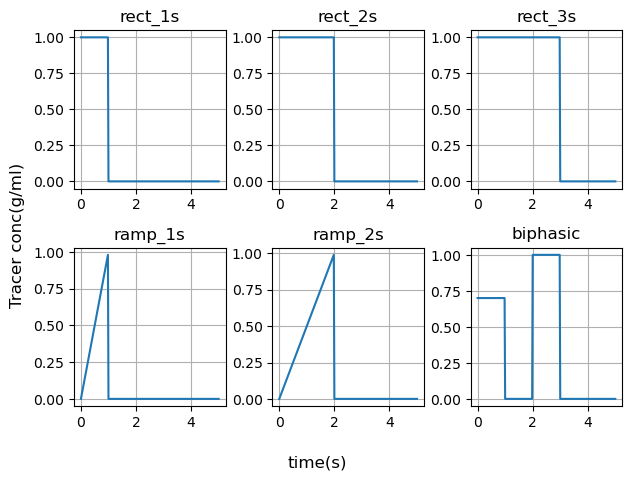

In [12]:
protocols = ['rect_1s', 'rect_2s', 'rect_3s', 'ramp_1s', 'ramp_2s', 'biphasic']
t = concdata.Time.to_numpy()
Tmax = t.max()
dt = 0.02
fig, axs = plt.subplots(nrows = 2, ncols = 3)
axs = axs.flatten()
for ax, protocol in zip(axs, protocols):
    #timedata = {'t_start':0, 'dt':dt, 't_end':Tmax}
    model = CSTRModel(timedata=t, inj_prot=protocol)
    c = model.cinj(t)  # injection concentrations
    ax.plot(t,c)
    ax.grid()
    ax.set_title(protocol)
fig.supylabel('Tracer conc(g/ml)')
fig.supxlabel('time(s)')
plt.tight_layout()

## Part 3 Fit data
### Manual fit

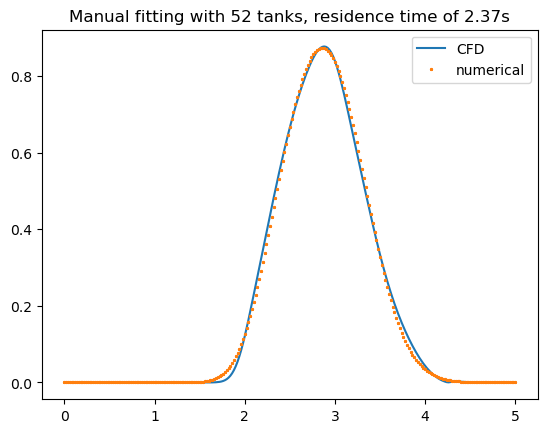

In [13]:
datafile = 'data/Healthy_rect_1s.csv' 
protocol ='rect_1s'
concdata = pd.read_csv(datafile)
t = concdata.Time.to_numpy()
conc_CFD = concdata.Concentration.to_numpy()
N = 52
tau = 2.37

model = CSTRModel(tau = tau, N= N, timedata=t, inj_prot=protocol)
conc_model = model.time_sim(N, tau)

fig, ax = plt.subplots()
ax.plot(t, conc_CFD, label = 'CFD')
ax.plot(t, conc_model,'*', markersize=2 ,label = 'numerical')
ax.set_title(f'Manual fitting with {N} tanks, residence time of {tau}s')
ax.legend()

In [14]:
datafile = 'data/Healthy_rect_1s.csv' 
protocol ='rect_1s'
concdata = pd.read_csv(datafile)
t = concdata.Time.to_numpy()
conc_CFD = concdata.Concentration.to_numpy()

## Use two loops of N and tau and check SSR for each combination and find the lowest SSR

In [15]:
SSR = 100
#dt=0.005
#timedata = {'t_start':0, 'dt':dt, 't_end':t[-1]}
timedata = t

for N in range(45, 52):
    for tau in np.arange(2.35,2.37,0.01):
        model = CSTRModel(tau = tau, N= N, timedata=timedata, inj_prot=protocol)
        conc_model = model.time_sim(N, tau)
        #conc_model = np.interp(t,model.ts,conc_model1 )
        SSR1 = (conc_CFD-conc_model)**2
        SSR1 = SSR1.sum()
        if SSR1 < SSR:
            print(f'Found new low: N={N}, tau={tau:.2f}, SSR={SSR1:.4f}')
            SSR = SSR1
            N_fit, tau_fit = N, tau
        


Found new low: N=45, tau=2.35, SSR=0.0652
Found new low: N=45, tau=2.36, SSR=0.0467
Found new low: N=45, tau=2.37, SSR=0.0425
Found new low: N=46, tau=2.36, SSR=0.0410
Found new low: N=46, tau=2.37, SSR=0.0370
Found new low: N=47, tau=2.37, SSR=0.0334
Found new low: N=48, tau=2.37, SSR=0.0314
Found new low: N=49, tau=2.37, SSR=0.0309


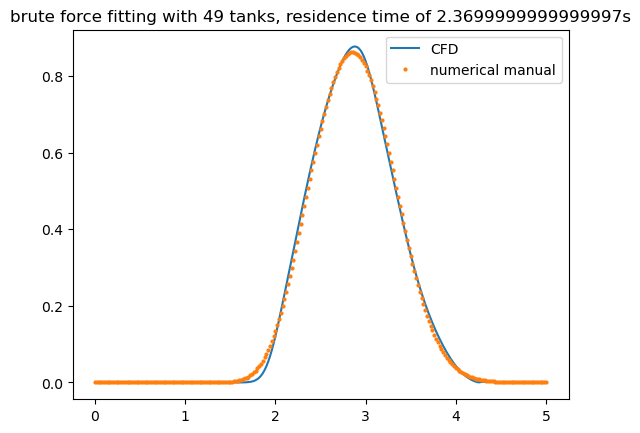

In [16]:
datafile = 'data/Healthy_rect_1s.csv' 
protocol ='rect_1s'
concdata = pd.read_csv(datafile)
t = concdata.Time.to_numpy()
conc_CFD = concdata.Concentration.to_numpy()


N = 52
tau = 2.37
model = CSTRModel(tau = tau, N= N, timedata=timedata, inj_prot=protocol)
#conc_model_manual = model.time_sim(N, tau)
conc_model_fitted = model.time_sim(N_fit, tau_fit)

fig, ax = plt.subplots()
ax.plot(t, conc_CFD, label = 'CFD')
#ax.plot(t, conc_model_manual,'*', markersize=2 ,label = 'numerical manual')
ax.plot(model.ts, conc_model_fitted,'o', markersize=2 ,label = 'numerical manual')

ax.set_title(f'brute force fitting with {N_fit} tanks, residence time of {tau_fit}s')
ax.legend()

In [17]:
def gradient(f,x, dx=10e-4,**kwarg):
    '''
    takes a function f and returns its gradient at x
    using central difference, 
    '''
    return (f(x+dx,**kwarg)-f(x-dx,**kwarg))/2/dx

In [18]:
def SSR(tau, xdata=[], ydata=[], N=1, inj_prot=protocol):
    
    timedata = xdata
    conc_CDF = ydata
    model = CSTRModel(tau=tau, N=N, timedata=timedata, inj_prot=protocol)
    conc_out = model.time_sim(N, tau)
    SSR = np.sum((conc_CFD-conc_out)**2)
    return SSR


In [ ]:
params = SSR{'xdata'=t, 'ydata'=conc_CFD, 'N'=N, 'inj_prot'='rect_1s'}
for tau in np.arange(2,3,0.1):
    

In [150]:
y = np.arange(45,53,1)
x = np.arange(2.36,2.372,0.0005)
print(f'N:{len(y)}  taus:{len(x)}')
X,Y = np.meshgrid(x, y) # grid of point
Z=[]
for x,y in (zip(X,Y)):
    z=[]
    for tau,N in (zip(x,y)):
        #print(_)
        z.append(SSR(tau= tau,N=N,xdata=t, ydata = conc_CFD))
    Z.append(z)
Z=np.array(Z)
idx=np.where(Z<0.031)
print(f'min error: {Z.min()}')

N:8  taus:25
min error: 0.030296792738394907


<IPython.core.display.Javascript object>


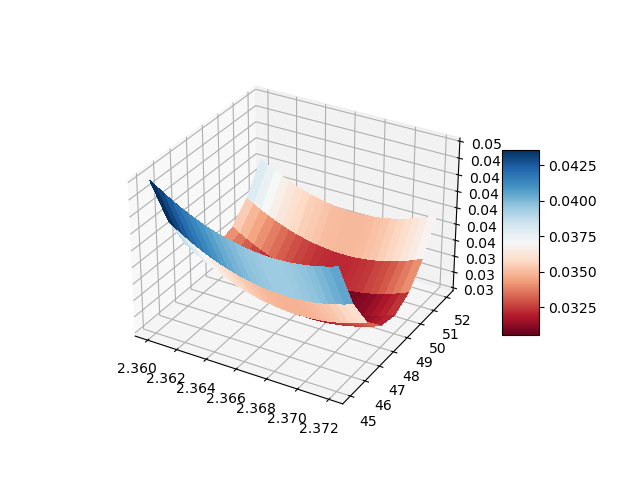

In [152]:
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection = '3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
#plt.close()
#

<IPython.core.display.Javascript object>


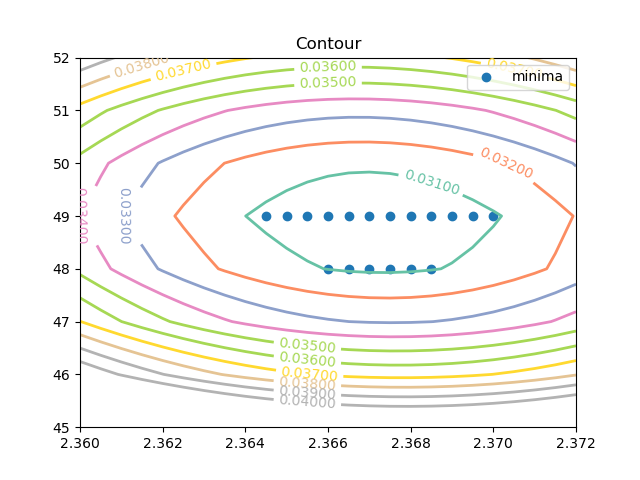

In [155]:
plt.figure()
cset = plt.contour(X,Y,Z,np.arange(0.03,0.04,0.001),linewidths=2,cmap=cm.Set2)
#cset=contour(X,Y,Z)
plt.clabel(cset,inline=True,fmt='%.5f',fontsize=10)
plt.scatter(X[idx],Y[idx], label='minima')
#plt.xlim(0,2)
#plt.ylim(0,2)
#colorbar(im) # adding the colobar on the right
plt.title('Contour')
a = plt.legend()


In [161]:
def gradient_descent(f,x,df, g=.001, prec=1e-8,MAXIT=10, **kwarg):
    '''Minimize f(x) by gradient descent.
    f   : min(f(x))
    x   : starting point 
    df  : derivative of f(x)
    g   : learning rate
    prec: desired precision
    
    Returns x when it is closer than eps to the root, 
    unless MAXIT are not exceeded
    '''
    x_old = x
    df_old=df(f,x_old,**kwarg)
    for n in range(MAXIT):
        #plot_regression_line(x_old)  
        x_new = x_old - g*df_old
        if(np.max(np.abs(x_new-x_old))<prec):
            print('Found solution:', x_new, 
                  ', after:', n, 'iterations.' )
            return x_new
        x_old=x_new
        df_old=df(f,x_old,**kwarg)
        
    print('Max number of iterations: ', MAXIT, ' reached.') 
    print('Try to increase MAXIT or decrease prec')
    print('Returning best guess, value of function is: ', x_guess:=f(x_new))
    return x_new,np.array(x_guess)

In [19]:
def dSSR(SSR,tau,**kwarg):
    return (gradient(SSR, tau,**kwarg))

In [172]:
N = 49
params = {'xdata':t, 'ydata':conc_CFD, 'N':N, 'inj_prot':'rect_1s'}
tau = 2.
optimal_tau = gradient_descent(f=SSR,x=tau,df=dSSR,MAXIT=200,**params)

Found solution: 2.3671063375654704 , after: 98 iterations.


In [175]:
timedata

{'t_start': 0, 'dt': 0.0001, 't_end': 1}

<IPython.core.display.Javascript object>


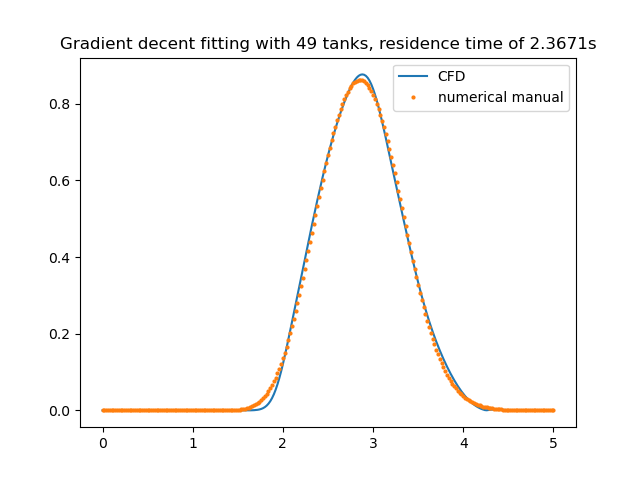

In [180]:
tau = optimal_tau
model = CSTRModel(tau = tau, N= N, timedata=t, inj_prot=protocol)
#conc_model_manual = model.time_sim(N, tau)
conc_model_fitted = model.time_sim(N, tau)

fig, ax = plt.subplots()
ax.plot(t, conc_CFD, label = 'CFD')
#ax.plot(t, conc_model_manual,'*', markersize=2 ,label = 'numerical manual')
ax.plot(model.ts, conc_model_fitted,'o', markersize=2 ,label = 'numerical manual')

ax.set_title(f'Gradient decent fitting with {N} tanks, residence time of {optimal_tau:.4f}s')
ax.legend()

In [182]:
def Jacobian(x,f,dx=1e-5,**kwarg):
    N=len(x)
    f0=f(x)
    J=np.zeros(shape=(N,N))
    for j in range(N):
        x[j] = x[j] +  dx
        fx=f(x)
        for i in range(N):   
            J[i][j] = (fx[i]-f0[i])/dx
        x[j] = x[j] -  dx
    return J

def newton_raphson(x,f,J=None, jacobian=False, prec=1e-8,MAXIT=10,**kwarg):
    '''Approximate solution of f(x)=0 by Newtons method.
    The derivative of the function is calculated numerically
    f   : f(x)=0.this is the derivative
    J   : Jacobian
    x   : starting point  
    eps : desired precision
    
    Returns x when it is closer than eps to the root, 
    unless MAX_ITERATIONS are not exceeded
    '''
    MAX_ITERATIONS=MAXIT
    x_old = np.copy(x)
    for n in range(MAX_ITERATIONS):
        plot_regression_line(x_old) 
        if not jacobian:
            J_=Jacobian(x_old,f)
        else:
            J_=J(x_old)
        z=np.linalg.solve(J_,-f(x_old))
        x_new=x_old+z
        if(np.sum(abs(x_new-x_old))<prec):
            print('Found solution:', x_new, 
                  ', after:', n, 'iterations.' )
            return x_new
        x_old=np.copy(x_new)
    print('Max number of iterations: ', MAXIT, ' reached.') 
    print('Try to increase MAXIT or decrease prec')
    print('Returning best guess, value of function is: ', f(x_new))
    return x_new

def J(b,x=x_obs_,y=y_obs_):
    N=len(b)
    J=np.zeros(shape=(N,N))
    xs=np.sum(x)
    J[0][0]=2*len(x)
    J[0][1]=2*xs
    J[1][0]=2*xs
    J[1][1]=2*np.sum(x*x)
    return J


TODO:
1. fix jacobian
1. bisection etc into a class
1. fit other 

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection = '3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
plt.close()
#%%
cset = plt.contour(X,Y,Z,np.arange(0,80,3),linewidths=2,cmap=cm.Set2)
#cset=contour(X,Y,Z)
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plt.scatter(x_guess[:,0],x_guess[:,1])
plt.xlim(0,2)
plt.ylim(0,2)
#colorbar(im) # adding the colobar on the right
#title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
#show()
# %%

In [38]:
def Jacobian(x,f,dx=1e-5):
    N=len(x)
    f0=f(x)
    J=np.zeros(shape=(N,N))
    for j in range(N):
        x[j] = x[j] +  dx
        fx=f(x)
        for i in range(N):   
            J[i][j] = (fx[i]-f0[i])/dx
        x[j] = x[j] -  dx
    return J

def newton_raphson(x,f,J=None, jacobian=False, prec=1e-8,MAXIT=10):
    '''Approximate solution of f(x)=0 by Newtons method.
    The derivative of the function is calculated numerically
    f   : f(x)=0.
    J   : Jacobian
    x   : starting point  
    eps : desired precision
    
    Returns x when it is closer than eps to the root, 
    unless MAX_ITERATIONS are not exceeded
    '''
    MAX_ITERATIONS=MAXIT
    x_old = np.copy(x)
    for n in range(MAX_ITERATIONS):
        plot_regression_line(x_old) 
        if not jacobian:
            J_=Jacobian(x_old,f)
        else:
            J_=J(x_old)
        z=np.linalg.solve(J_,-f(x_old))
        x_new=x_old+z
        if(np.sum(abs(x_new-x_old))<prec):
            print('Found solution:', x_new, 
                  ', after:', n, 'iterations.' )
            return x_new
        x_old=np.copy(x_new)
    print('Max number of iterations: ', MAXIT, ' reached.') 
    print('Try to increase MAXIT or decrease prec')
    print('Returning best guess, value of function is: ', f(x_new))
    return x_new

def gradient_descent(f,x,df, g=.001, prec=1e-8,MAXIT=10):
    '''Minimize f(x) by gradient descent.
    f   : min(f(x))
    x   : starting point 
    df  : derivative of f(x)
    g   : learning rate
    prec: desired precision
    
    Returns x when it is closer than eps to the root, 
    unless MAXIT are not exceeded
    '''
    x_old = x
    df_old=df(x_old)
    for n in range(MAXIT):
        plot_regression_line(x_old)  
        x_new = x_old - g*df_old
        if(np.max(np.abs(x_new-x_old))<prec):
            print('Found solution:', x_new, 
                  ', after:', n, 'iterations.' )
            return x_new
        x_old=x_new
        df_old=df(x_old)
        
    print('Max number of iterations: ', MAXIT, ' reached.') 
    print('Try to increase MAXIT or decrease prec')
    print('Returning best guess, value of function is: ', x_guess:=f(x_new))
    return x_new,np.array(x_guess)

def S(b,x=x_obs_,y=y_obs_):
    b0,b1=b
    return np.sum((y-b0-b1*x)**2)

def dS(b,x=x_obs_,y=y_obs_):
    return np.array([-2*np.sum(y-b[0]-b[1]*x),
                     -2*np.sum((y-b[0]-b[1]*x)*x)])

Gradient 
2


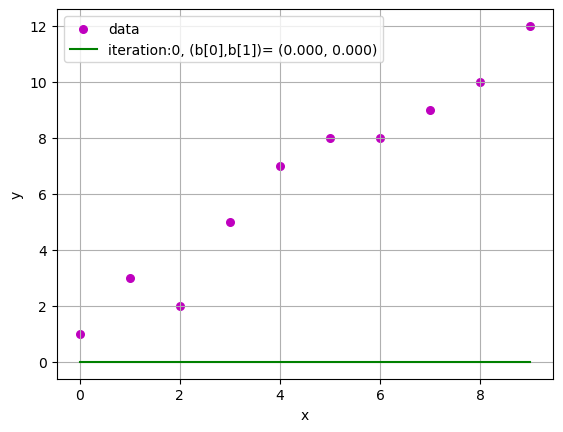

2


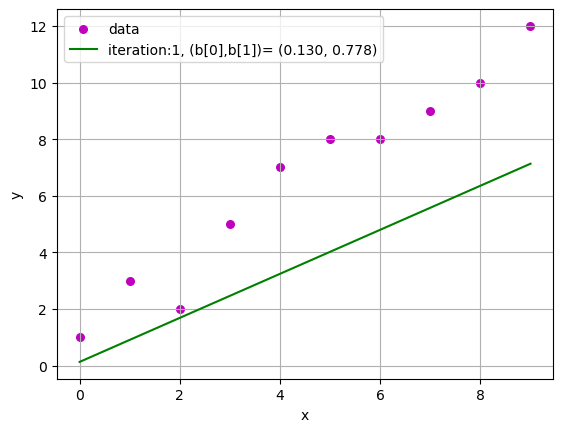

2


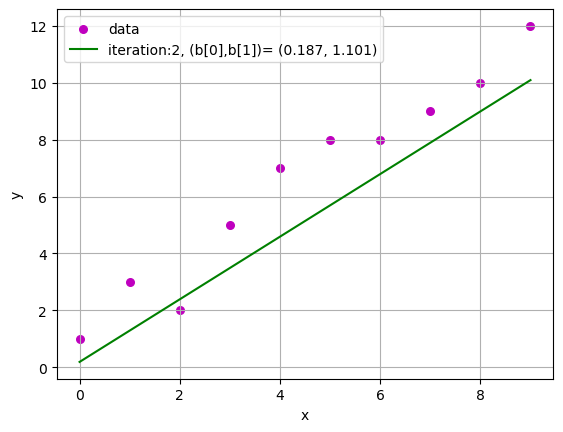

2


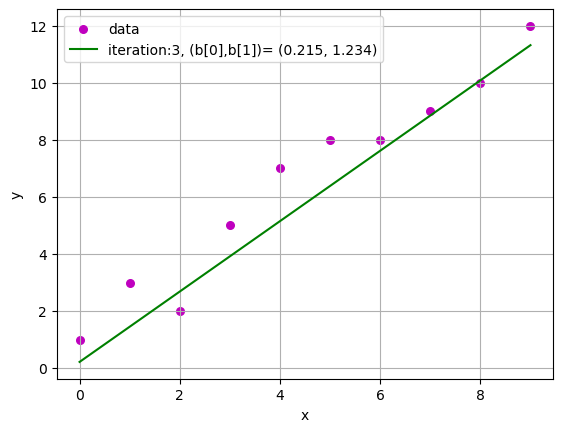

2


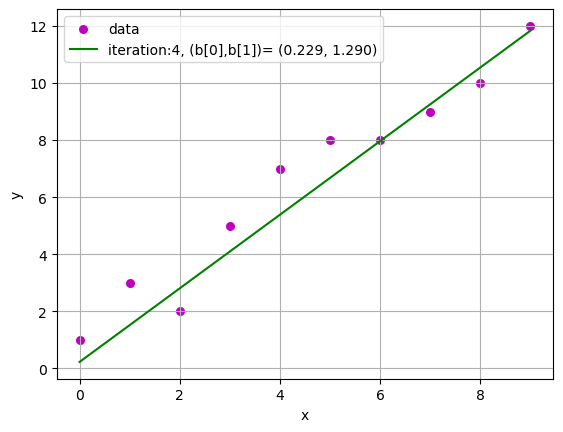

2


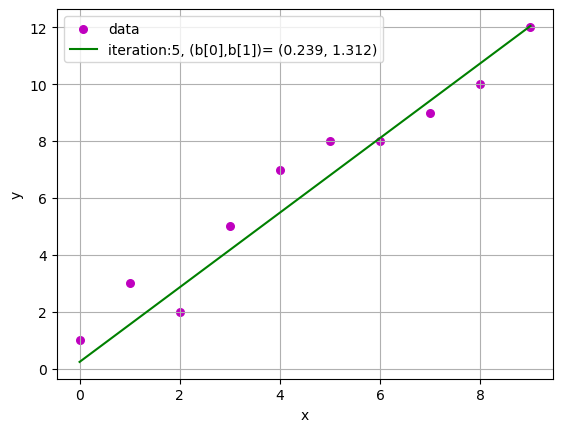

2


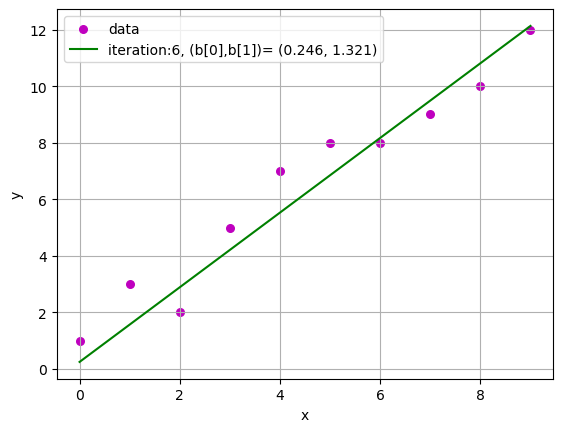

2


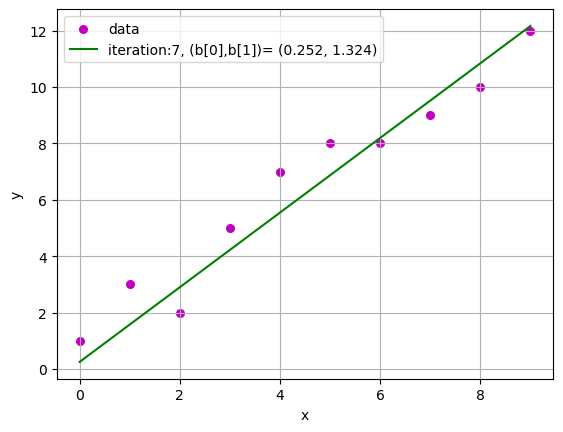

2


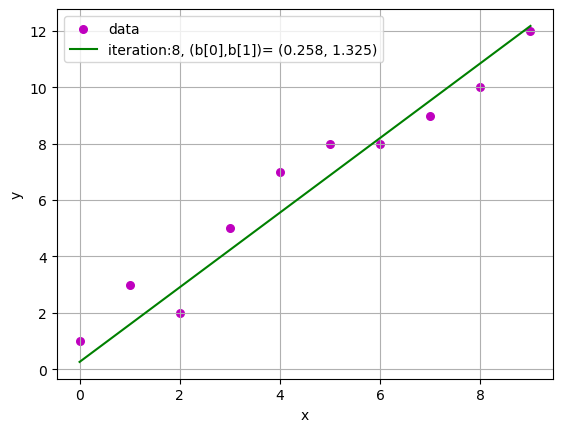

2


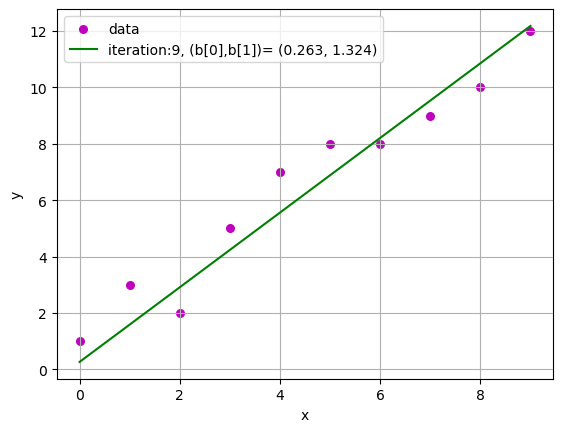

Max number of iterations:  10  reached.
Try to increase MAXIT or decrease prec
Returning best guess, value of function is:  8.334112068819337
Newtons method
2


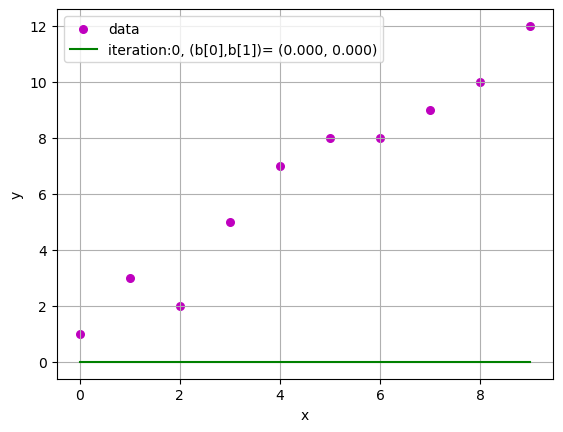

2


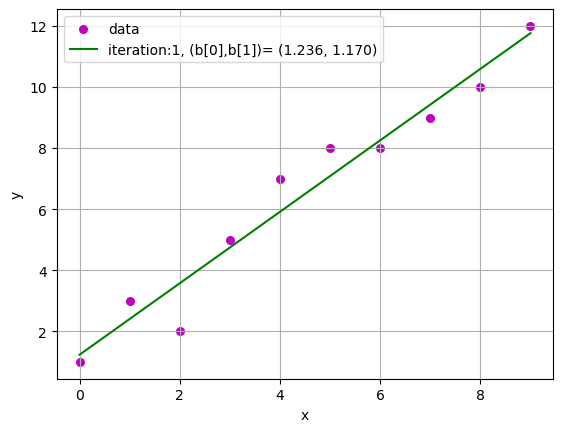

Found solution: [1.23636364 1.16969697] , after: 1 iterations.


In [39]:
#%%
N_=0
print('Gradient ')
b=np.array([0,0])
b,x_guess=gradient_descent(S,b,dS,g=0.001,MAXIT=10)
# %%
print('Newtons method')
N_=0
b=np.array([0,0])
b=[0,0]
b=[0.,0.]
b2=newton_raphson(b,dS,jacobian=False)
# %%

In [20]:
concdata

,Time,Concentration
0,0.00,0.000000e+00
1,0.02,0.000000e+00
2,0.04,0.000000e+00
3,0.06,0.000000e+00
4,0.08,0.000000e+00
...,...,...
246,4.92,8.620000e-06
247,4.94,4.980000e-06
248,4.96,2.020000e-06
249,4.98,2.510000e-08
